# Feature selection in behavior prediction with XGBoost

Copyright 2021 -
Leon Kellner, Hamburg University of Technology, Germany

https://www2.tuhh.de/skf/

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## 0.1 Packages

In [1]:
# clear jupyter lab workspace without user confirmation
%reset -f  

# --- data handling modules
import pandas as pd
import numpy as np

# --- machine learning modules 
# - pre- & postprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# - XGBoost
import xgboost as xgb

# - explainable AI
import shap

# --- visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# --- other
import importlib
import pickle

# --- inhouse modules
import auxiliary_functions as aux  # repeatedly used functions are outsourced to this module
import data_preprocessing as dp    # data preprocessing module
importlib.reload(dp)  # automatic reload (sometimes needed)
importlib.reload(aux)

<module 'auxiliary_functions' from 'H:\\011_numerical\\05b_Feature_selection_PhD\\coding\\auxiliary_functions.py'>

## 0.2 Variables and constants

In [2]:
# --- control variables
# - data cleaning
freshwater_ = False     # only use freshwater ice data t/f
onehot_ = False        # one-hot encode data t/f
drop_nan_ = False      # drop all rows that contain nan values after data cleaning t/f, not necessary for XGBoost trees
exp_cat_ = False       # Take exponential of ordinally encoded categorical data to increase distance between categories

# - code execution
use_kfold = False       # check for overfitting with kfold cross validation
exploratory = False     # do exploratory data analysis  t/f
random_state_ = 7       # random state for reproducible output (can be set to None if not needed) 
tex_export = False      # Use pgf & tex to export PDFs that look "latex-ish"

# --- global training constants and hyperparameters
# see also https://xgboost.readthedocs.io/en/latest/parameter.html
MAX_LEAVES = 8             # p. 363, T. Hastie et al., The elements of statistical learning: Data mining, inference, and prediction, 2009.
LEARNING_RATE = 0.07       # J. H. Friedman, “Stochastic gradient boosting,” Computational Statistics & Data Analysis, vol. 38, no. 4, pp. 367–378, 2002
SUBSAMPLE = 0.5            # Also Friedman paper
NUM_BOOST_ROUNDS = 500     # Number of gradient boosted trees. Equivalent to number of boosting rounds.
EARLY_STOPPING_ROUNDS = 5  # Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training
EVAL_METRICS = ['auc', 'logloss']  # last metric in this list will be used for early stopping during training
OBJECTIVE = "binary:logistic"      # logistic regression loss function for binary classification

# --- file name templates for saving files, figures and models
fig_path_name_template = "raw_figures/clf_xgb_sw_"    
excel_path_name_template = 'excel_outputs/clf_xgb_sw_'
model_path_name_template = 'models/clf_xgb_sw_'
if freshwater_:
    fig_path_name_template = "raw_figures/clf_xgb_fw_"
    excel_path_name_template = 'excel_outputs/clf_xgb_fw_'
    model_path_name_template = 'models/clf_xgb_fw_'
    
# --- Figure export settings
constrained_layout_ = True
dpi_ = 1000                     # resolution for figures
fig_size_ = aux.cm2inch(9.8, 7)  # figure size

# Settings for tex export
if tex_export:
    font_size_ = 10
    mpl.use("pgf")
    plt.rcParams['axes.axisbelow'] = True  # Axis grid lines below other plot elements
    plt.rcParams.update({
        'font.size' : font_size_,       # Set font size
        'axes.labelsize': font_size_,   # -> axis labels
        'legend.fontsize': font_size_,  # -> legends
        "font.family": "serif",         # use serif/main font for text elements
        "text.usetex": True,            # use inline math for ticks
        "pgf.texsystem": "lualatex",
        "figure.max_open_warning" : 0,
        "pgf.rcfonts": False,          # don't setup fonts from rc parameters
        "pgf.preamble": "\n".join([
             r"\usepackage{unicode-math}",      # unicode math setup
             r"\usepackage{libertinus}",
             r"\setmainfont{Libertinus Math}",  # font via preamble
        ])
    })

## 1. Import and prepare data

In [3]:
file = 'data points_v1.16.xlsx'
data = dp.data_cleaning(filename=file)  # method agnostic initial data cleaning

# method specific data cleaning & split into encoded and non-encoded data
# Display datasets are not encoded or scaled, and will be used in visualization later
X, y, X_display, y_display = dp.data_prep_behavior_pred(data, freshwater=freshwater_, onehot=onehot_, 
                                                        drop_nan=drop_nan_, exp_cat=exp_cat_)
num_features = X.shape[1]
num_samples = data.shape[0]
X.to_excel(excel_path_name_template + 'X.xlsx',index=True, header=True)
X_display.to_excel(excel_path_name_template + 'X_display.xlsx',index=True, header=True)

# train, test, and validation splits
split = 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=split, stratify=y, random_state = random_state_)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split, stratify=y_train_val, random_state = random_state_)  

# tidy features names for later visualizations 
# --- This code snippet is based on:
# S. Lundberg et al., TreeExplainer Study, 2020, GitHub repository, https://github.com/suinleelab/treeexplainer-study
if freshwater_:
    name_map = {
        "strain_rate": "Strain rate",
        "triaxiality": "Triaxiality",
        "temperature": "Temperature",
        "volume": "Volume",
        "porosity": "Porosity",
        "grain_size": "Grain size", 
        "type_test": "Type of test",
        "columnar_loading": "Columnar loading",
        "type_ice": "Type of ice",
    }
else:
    name_map = {
        "temperature": "Temperature",
        "columnar_loading": "Columnar loading",
        "strain_rate": "Strain rate",
        "type_ice": "Type of ice",
        "porosity": "Porosity",
        "volume": "Volume",
        "type_test": "Type of test",
        "salinity": "Salinity", 
        "triaxiality": "Triaxiality",
    }
display_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))
# --- until here

X_display.head()

Uniaxial tension and shear tests removed from data set.
Binarized behavior:  brittle  =  0
Encoded columnar loading:  across  =  0
Encoded type of ice:  columnar  =  0.0


,type_test,strain_rate,temperature,grain_size,porosity,salinity,type_ice,columnar_loading,triaxiality,volume
original_index,,,,,,,,,,
330,uniaxial compression,-0.800894,-11.0,NaN,NaN,2.4,columnar,across,-0.333333,432000.0
331,uniaxial compression,-0.904736,-11.0,NaN,NaN,2.4,columnar,across,-0.333333,432000.0
332,uniaxial compression,-1.178982,-11.0,NaN,NaN,2.4,columnar,across,-0.333333,432000.0
333,uniaxial compression,-0.929590,-11.0,NaN,NaN,2.4,columnar,across,-0.333333,432000.0
334,uniaxial compression,-0.798099,-11.0,NaN,NaN,2.4,columnar,across,-0.333333,432000.0


## 1.1 Exploratory data analysis

In [4]:
if exploratory:
    # check and output shapes and features
    print(X.shape, y.shape, X_display.shape, y_display.shape)   
    print(f'number of input feautures: {num_features}')
    print(f'number of samples (overall): {num_samples}')

    # a histogram of all inputs
    hist_inputs = X.hist(layout=(3,3), figsize=(10,10));
    plt.show()

    # a histogram of all outputs
    print('targets: number of behavior type 1: ' + str(np.sum(y)))
    print('targets: number of behavior type 0: ' + str(len(y)-np.sum(y)))
    print('the imbalance is: ' + str(np.sum(y)/y.shape*100) + ':' + str((len(y)-np.sum(y))/y.shape*100))
    print('the expected value is:' + str(np.round(np.mean(y),2)))
    hist_outputs = y.hist();
    plt.xlabel('target value')
    plt.show()

## 2. XGBoost model preparation & cross validation 

In [5]:
# --- model building and training function
def build_train_model(Dtrain, Deval):
    """Build and train XGBoost model.

    Parameters
    ----------
    Dtrain, Dtest : xgboost.DMatrix
        Train and test/evaluation data sets in native XGBoost format.


    Returns
    -------
    xgboost.Booster, dictionary

    """
    parameters_booster = {
        "max_leaves": MAX_LEAVES,             
        "grow_policy": 'lossguide',  # needs to be defined for max_leaves parameter
        "tree_method": 'hist',       # needs to be defined for max_leaves parameter
        "learning_rate": LEARNING_RATE,       
        "subsample": SUBSAMPLE,            
        "objective": OBJECTIVE,     
        "eval_metric": EVAL_METRICS,  
    }
    progress = dict()  # training progress
    
    # compile and train model, return model and training progress
    model = xgb.train(parameters_booster, Dtrain, verbose_eval=False,  
                      evals=[(Dtrain, 'train'), (Deval, 'eval')],
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      evals_result=progress, num_boost_round=NUM_BOOST_ROUNDS)
    return model, progress

# --- model checking
# use cross validation to find out whether the model architecture is well suited for the problem
metrics_cv = {'acc': [], 'mcc': []}  # store the results in a dict
if use_kfold:  
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = random_state_)
    for train, test in kfold.split(X_train_val, y_train_val):
        
        # split fold test data into validation set for early stopping and test set for performance evaluation
        Xfold_eval, Xfold_test, yfold_eval, yfold_test = train_test_split(X_train_val.iloc[test, :], y_train_val.iloc[test], test_size=0.5, 
                                                                          stratify=y_train_val.iloc[test], random_state = random_state_)
        Dtrain = xgb.DMatrix(X_train_val.iloc[train, :], y_train_val.iloc[train])  # the current training data in native XGBoost format
        Deval = xgb.DMatrix(Xfold_eval, yfold_eval)     # Validation data for early stopping
        model, progress = build_train_model(Dtrain, Deval)
        current_metrics = aux.binary_classif_metrics_xgb(model, Xfold_test, yfold_test)  # evaluation of model performance on current test data 
        metrics_cv['mcc'].append(current_metrics[0])
        metrics_cv['acc'].append(current_metrics[1])
        
        print(len(yfold_eval), len(yfold_test))
    
    # add mean of kfold metric values
    metrics_cv['acc_mean'] = np.mean(metrics_cv['acc'])
    metrics_cv['mcc_mean'] = np.mean(metrics_cv['mcc'])
    
    # report the CV results
    print('cross-validation performance ACC :', np.round(metrics_cv['acc'], 2), ', mean: ', str(np.round(metrics_cv['acc_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['acc'])))
    print('cross-validation performance MCC :', np.round(metrics_cv['mcc'], 2), ', mean: ', str(np.round(metrics_cv['mcc_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['mcc'])))

## 3. Train the final classifier

test set score of the final classifier - ACC:  0.87
test set score of the final classifier - MCC:  0.69


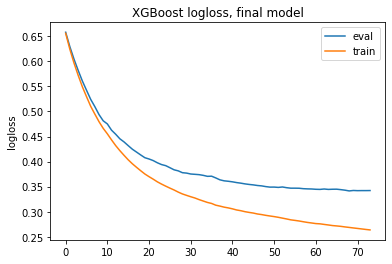

In [6]:
metrics_final = {}
Dtrain = xgb.DMatrix(X_train, y_train)  # convert training data to XGBoost native data format
Deval = xgb.DMatrix(X_val, y_val)

# build final model, save training progress, and get predictions
model, progress_final = build_train_model(Dtrain, Deval)
pickle.dump(model, open(model_path_name_template + "pickle.dat", "wb"))

# report the results of the final classifier on the test data set
metrics_final['mcc_test'], metrics_final['acc_test'] = aux.binary_classif_metrics_xgb(model, X_test, y_test)
print('test set score of the final classifier - ACC: ', str(np.round(metrics_final['acc_test'],2)))
print('test set score of the final classifier - MCC: ', str(np.round(metrics_final['mcc_test'],2)))

# plot the training history of the final classifier
plot_metric = aux.is_list(EVAL_METRICS, -1)  # If eval_metric is list, get last entry (used for early stopping)
x_axis = range(0, len(progress_final['eval'][plot_metric]))
fig, ax = plt.subplots()
ax.plot(x_axis, progress_final['eval'][plot_metric], label='eval')
ax.plot(x_axis, progress_final['train'][plot_metric], label='train')
ax.legend()
plt.ylabel(plot_metric)
plt.title('XGBoost ' + plot_metric + ', final model')
plt.show()

# use the following hack for shap 1.1 until this issue is fixed: https://github.com/slundberg/shap/issues/1215
# https://github.com/slundberg/shap/issues/1215#issuecomment-641102855
model_bytearray = model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
model.save_raw = myfun

## 4. Postprocessing of results

## 4.1 Confusion matrix and test/misclassified data subsets

In [7]:
y_predict = model.predict(xgb.DMatrix(X_test))
y_predict = (y_predict > 0.5).astype(int)  # convert probabilities to classes
y_predict_df = pd.DataFrame(y_predict)     # predicted classes as pandas dataframe
y_misclassified = ~(y_test == y_predict)   # boolean vector for test predictions, where y_miscl[i] is true if the model misclassified observation X_test[i]
X_test_misclassified = X_test.loc[y_misclassified.values, :]  # take only misclassified observations

# save different datasets as excel tables for external use
y_predict_df.to_excel(excel_path_name_template + 'y_predict.xlsx',index=False, header=False)  
y_test.to_excel(excel_path_name_template + 'y_test.xlsx',index=False, header=False)
X_test.to_excel(excel_path_name_template + 'X_test.xlsx',index=True, header=True)
X_test_misclassified.to_excel(excel_path_name_template + 'X_test_misclassified.xlsx',index=True, header=True)
del y_predict_df

# Double check shapes, if desired
#print(X_test.shape)
#print(y_test.shape)
#print(y_predict.shape)
#print(y_misclassified.shape)
#print(X_test_misclassified.shape)

## 4.2 Explain predictions for all observations

In [8]:
shap.initjs()  # necessary for shap visualization
print('The binarized value of', y_display.iloc[0], 'behavior is', y.iloc[0])  # Output binarized and display value
    
explainer = shap.TreeExplainer(model)   # if no background data is given, feature perturbation is automatically observational (https://shap.readthedocs.io/en/latest/#shap.TreeExplainer)
shap_values = explainer.shap_values(X)  # SHAP values for all data. This is fast for boosted trees, no specific background data needed (in contrast to KernelExplainer)

# save test shap values to excel
df_shap_values = pd.DataFrame(shap_values)  # create dataframe for shap values
df_shap_values.to_excel(excel_path_name_template + 'shap_values.xlsx',index=True, header=True) 

# check shape if desired - should be the same as data matrix
print('Shape of shap values: ', shap_values.shape)  
print('Shape of data matrix: ', X.shape)

The binarized value of brittle behavior is 0
Shape of shap values:  (1820, 10)
Shape of data matrix:  (1820, 10)


### Importance of features
SHAP importance ranking for the complete data set. 

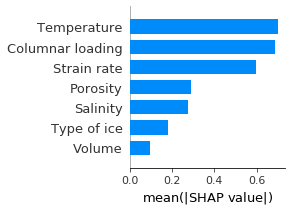

In [9]:
max_display_ = 7  # max. number of features to include in plots
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, feature_names=display_feature_names, plot_type="bar", plot_size=None, 
                  show=False, max_display=max_display_)
plt.xlabel("mean($|$SHAP value$|$)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar.pdf", format='pdf',  dpi=dpi_)  
#plt.show

### SHAP summary plot

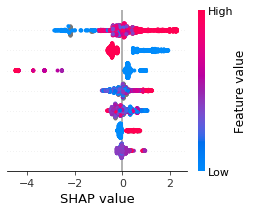

In [10]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, 
                  feature_names=["" for m in display_feature_names],  # omit feature names in this summary plot
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.xlabel("SHAP value")
plt.savefig(fig_path_name_template + "summary.pdf", dpi=dpi_, format='pdf')

## 4.4 Analysis of SHAP values for test and misclassified observations
### Have a closer look at SHAP values for test data.

In [11]:
shap_values_test = explainer.shap_values(X_test)      # Estimate SHAP values for testing data
df_shap_values_test = pd.DataFrame(shap_values_test)  # create dataframe for test shap values

# save test shap values to excel
df_shap_values_test.to_excel(excel_path_name_template + 'shap_values_test.xlsx',index=True, header=True)  

# locate misclassified values and save to excel file
df_shap_values_test.loc[y_misclassified.values, :].to_excel(excel_path_name_template + 'shap_values_test_misclassified.xlsx',index=True, header=True)  

Plot ranking and summary plot for test data only

<function matplotlib.pyplot.show(*args, **kw)>

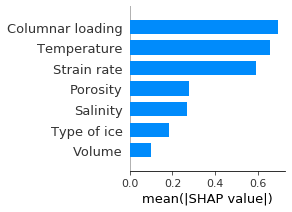

In [12]:
max_display_ = 7

f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test, X_test, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_testdata.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

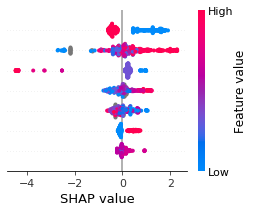

In [13]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test, X_test, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.xlabel("SHAP value")
plt.savefig(fig_path_name_template + "summary_testdata.pdf", dpi=dpi_, format='pdf')
plt.show

## 4.5 Interaction effects
### Have a look at dependence plots of all feature combinations and save noteworthy ones 

### Save specific dependence plots

In [14]:
# Model function call to incorporate DMatrix format
# For some plotting functions this is needed
# Otherwise either the model complains that its input is not DMatrix, or the
# plotting function complains that DMatrix has no shape attribute
def model_funct(X):
    return model.predict(xgb.DMatrix(X))

invalid value encountered in less


<Figure size 432x288 with 0 Axes>

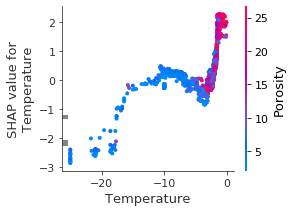

In [15]:
plotme = True
if plotme:
    f = plt.figure()
    interaction_index_ = 'Porosity'
    shap.dependence_plot('Temperature', shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False)
    plt.gcf().set_size_inches(fig_size_)  # this line might be needed if dependence plot ignores figure size setting
    plt.tight_layout(pad=0)
    plt.savefig(fig_path_name_template + "dependence_temperature_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

invalid value encountered in less


<Figure size 432x288 with 0 Axes>

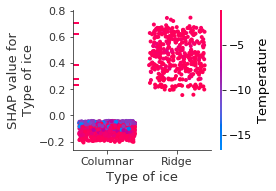

In [16]:
x_jitter_ = 0.8
plotme = True
if plotme:
    f = plt.figure()
    interaction_index_ = 'Temperature'
    shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

invalid value encountered in less


<Figure size 432x288 with 0 Axes>

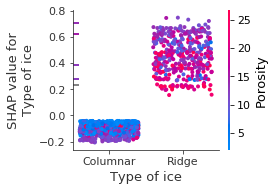

In [17]:
plotme = True
if plotme:
    f = plt.figure()
    interaction_index_ = 'Porosity'
    shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

<Figure size 432x288 with 0 Axes>

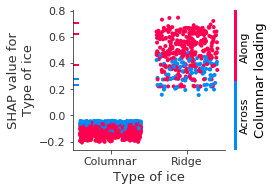

In [18]:
plotme = True
if plotme:
    f = plt.figure()
    interaction_index_ = 'Columnar loading'
    shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticklabels(['Across', 'Along'])
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
    cbar.set_ticks([0.35, 0.82])
    plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

<Figure size 432x288 with 0 Axes>

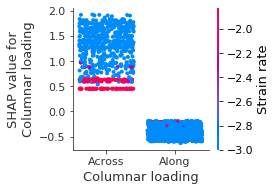

In [19]:
plotme = True
if plotme:
    f = plt.figure()
    main_index = 'Columnar loading'
    interaction_index_ = 'Strain rate'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    plt.xticks(np.arange(2), ('Across', 'Along'))
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

invalid value encountered in less


<Figure size 432x288 with 0 Axes>

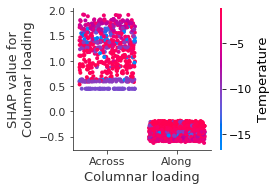

In [20]:
plotme = True
if plotme:
    f = plt.figure()
    main_index = 'Columnar loading'
    interaction_index_ = 'Temperature'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    plt.xticks(np.arange(2), ('Across', 'Along'))
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

<Figure size 432x288 with 0 Axes>

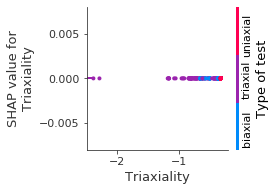

In [21]:
plotme = True
if plotme:
    f = plt.figure()
    main_index = 'Triaxiality'
    interaction_index_ = 'Type of test'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticklabels(['biaxial', 'triaxial', 'uniaxial'])
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
    cbar.set_ticks([0.5, 1.2, 1.85])
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
    plt.show

In [22]:
plotme = True
if plotme and freshwater_:
    f = plt.figure()
    main_index = 'Grain size'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=None, show=False, x_jitter=2)
    plt.gcf().set_size_inches(fig_size_) 
    #plt.tight_layout()

    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + ".pdf", dpi=dpi_, format='pdf')
    plt.show

In [23]:
plotme = True
if plotme and freshwater_:
    fig, ax_ = plt.subplots(constrained_layout=True, figsize=fig_size_)
    main_index = 'Grain size'
    #ax_ = plt.gca

    fig = shap.partial_dependence_plot(
        "grain_size", model_funct, X, model_expected_value=False, 
        feature_expected_value=False, show=False, ice=False, ax=ax_
    )
    ax_.set_xlabel("Grain size [mm]")
    ax_.set_ylabel("E[f(x) $|$ Grain size]")
    #plt.tight_layout(pad=pad_)
    plt.savefig(fig_path_name_template + "partial_dependence_" + main_index + ".pdf", dpi=dpi_, format='pdf')
    plt.show

<Figure size 432x288 with 0 Axes>

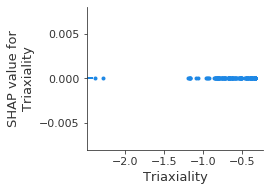

In [24]:
plotme = True
if plotme:
    f = plt.figure()
    main_index = 'Triaxiality'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=None, show=False, x_jitter=2)
    #shap.plots.scatter(explainer.shap_values[:,"triaxiality"], hist=True, 
    #                   alpha=1, show=False)
    plt.gcf().set_size_inches(fig_size_) 
    plt.tight_layout()
    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + ".pdf", dpi=dpi_, format='pdf')
    plt.show

invalid value encountered in greater_equal
invalid value encountered in less_equal


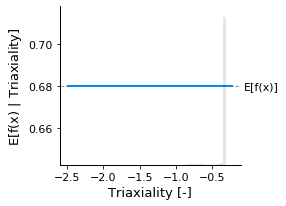

In [25]:
plotme = True
if plotme:
    fig, ax_ = plt.subplots(constrained_layout=True, figsize=fig_size_)
    main_index = 'Triaxiality'

    #ax_ = plt.gca

    fig = shap.partial_dependence_plot(
        "triaxiality", model_funct, X, model_expected_value=True, 
        feature_expected_value=True, show=False, ice=False, ax=ax_
    )
    ax_.set_xlabel("Triaxiality [-]")
    ax_.set_ylabel("E[f(x) $|$ Triaxiality]")
    #plt.ylabel("E(f(x)$|$ Strain rate)")
    #plt.tight_layout(pad=pad_)
    plt.savefig(fig_path_name_template + "partial_dependence_" + main_index + ".pdf", dpi=dpi_, format='pdf')
    plt.show

invalid value encountered in less


<Figure size 277.795x198.425 with 0 Axes>

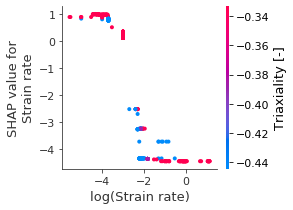

In [26]:
plotme = True
if plotme:
    f = plt.figure(figsize=fig_size_, constrained_layout=True)
    main_index = 'Strain rate'
    shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index="Triaxiality", show=False)
    plt.gcf().set_size_inches(fig_size_) 
    cbar = plt.gca().collections[0].colorbar
    cbar.ax.set_ylabel('Triaxiality [-]')
    plt.tight_layout(pad=0.1)
    plt.xlabel("log(Strain rate)")
    plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + ".pdf", dpi=dpi_, format='pdf')
    plt.show

<function matplotlib.pyplot.show(*args, **kw)>

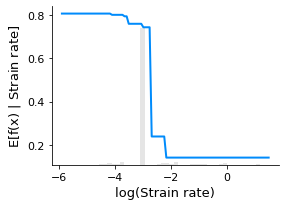

In [27]:
fig, ax_ = plt.subplots(constrained_layout=True, figsize=fig_size_)
main_index = 'Strain rate'

fig = shap.partial_dependence_plot(
    "strain_rate", model_funct, X, model_expected_value=False, 
    feature_expected_value=False, show=False, ice=False, ax=ax_
)
ax_.set_xlabel("log(Strain rate)")
ax_.set_ylabel("E[f(x) $|$ Strain rate]")
#plt.tight_layout()
plt.savefig(fig_path_name_template + "partial_dependence_" + main_index + ".pdf", dpi=dpi_, format='pdf')
plt.show

### Plot all combinations
If desired, have a look at all possible feature combinations.

In [28]:
raise SystemExit("Stop right there!")  # Stop code execution if desired

for feature in display_feature_names:
    for interaction_feature in display_feature_names:
        if interaction_feature != feature:
            shap.dependence_plot(feature, shap_values, X, feature_names=np.array(display_feature_names), 
                                 interaction_index=interaction_feature, x_jitter=0.1)

SystemExit: Stop right there!

To exit: use 'exit', 'quit', or Ctrl-D.
